In [1]:
from matplotlib.pyplot import figure, grid, legend, plot, show, xlabel
from numpy import array, concatenate, cos, linspace, sin, zeros
from numpy.linalg import solve

from main import AffineDynamics, FBLinController, RoboticDynamics, SystemDynamics

$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$
$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2}}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2}}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$
$\newcommand{\R}{\bb{R}}$

# Cart-Pole Simulation

Consider a cart-pole system specified as follows:

- A cart of mass $M$ moves on a frictionless track with horizontal force as control input.
- A massless rod of length $l$ is attached to a frictionless joint above the cart center-of-mass.
- A point mass $m$ is attached to the other end of the rod.

We measure horizontal position, $x$, velocity, $\dot{x}$, angle from upright, $\theta$, and angular rate, $\dot{\theta}$. We would like to stabilize the cart upright; that is, we would like to drive $\theta \to 0$.

Let the position of the cart and point mass be $\mb{r}_c = (x, 0)$ and $\mb{r}_p = (x + l\sin{\theta}, l\cos{\theta})$, respectively, in an inertial frame. The total kinetic energy of the system is:

\begin{align}
    K &= \frac{1}{2} M \norm{\dot{\mb{r}}_c}^2 + \frac{1}{2} m \norm{\dot{\mb{r}}_p}^2\\
    &= \frac{1}{2} M \dot{x}^2 + \frac{1}{2}m (\dot{x}^2 + 2l\dot{x}\dot{\theta}\cos{\theta} +l^2\dot{\theta}^2\cos^2{\theta} + l^2\dot{\theta}^2\sin^2{\theta})^2\\
    &= \frac{1}{2}(M + m)\dot{x}^2 + ml\dot{x}\dot{\theta}\cos{\theta} + \frac{1}{2}ml^2\dot{\theta}^2,
\end{align}

and the potential energy of the system is $U = mgl\cos{\theta}$, yielding Lagrangian:

\begin{equation}
    L = K - U = \frac{1}{2}(M + m)\dot{x}^2 + ml\dot{x}\dot{\theta}\cos{\theta} + \frac{1}{2}ml^2\dot{\theta}^2 - mgl\cos{\theta}.
\end{equation}

With generalized coordinates $\mb{q} = (x, \theta)$ and generalized force $F$, we have:

\begin{align}
    \der{}{t}\derp{L}{\dot{\mb{q}}} - \derp{L}{\mb{q}} &= \der{}{t}\begin{bmatrix} (M + m)\dot{x} + ml\dot{\theta}\cos{\theta} \\ ml\dot{x}\cos{\theta} + ml^2\dot{\theta} \end{bmatrix} - \begin{bmatrix} 0 \\ -ml\dot{x}\dot{\theta}\sin{\theta} + mgl\sin{\theta} \end{bmatrix}\\
    &= \begin{bmatrix} (M + m)\ddot{x} + ml\ddot{\theta}\cos{\theta} - ml\dot{\theta}^2\sin{\theta} \\ ml\ddot{x}\cos{\theta} - ml\dot{x}\dot{\theta}\sin{\theta} + ml^2\ddot{\theta} \end{bmatrix} - \begin{bmatrix} 0 \\ -ml\dot{x}\dot{\theta}\sin{\theta} + mgl\sin{\theta} \end{bmatrix}\\
    &= \underbrace{\begin{bmatrix} M + m & ml\cos{\theta} \\ ml\cos{\theta} & ml^2 \end{bmatrix}}_{\mb{D}(\mb{q})} \underbrace{\begin{bmatrix} \ddot{x} \\ \ddot{\theta} \end{bmatrix}}_{\ddot{\mb{q}}} + \underbrace{\begin{bmatrix} - ml\dot{\theta}^2\sin{\theta} \\ - mgl\sin{\theta} \end{bmatrix}}_{\mb{H}(\mb{q}, \dot{\mb{q}})} = \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{\mb{B}} \underbrace{F}_{\mb{u}},
\end{align}

or as a first-order system:

\begin{equation}
    \underbrace{\der{}{t}\begin{bmatrix} \mb{q} \\ \dot{\mb{q}} \end{bmatrix}}_{\dot{\mb{x}}} = \underbrace{\begin{bmatrix} \dot{\mb{q}} \\ -\mb{D}(\mb{q})^{-1}\mb{H}(\mb{q}, \dot{\mb{q}}) \end{bmatrix}}_{\mb{f}(\mb{x})} + \underbrace{\begin{bmatrix} \mb{0}_{2 \times 1} \\ \mb{D}(\mb{q})^{-1}\mb{B} \end{bmatrix}}_{\mb{g}(\mb{x})}\mb{u}
\end{equation}

where state $\mb{x} = (\mb{q}, \dot{\mb{q}}) = (x, \theta, \dot{x}, \dot{\theta})$. Since $\det{(\mb{D}(\mb{q}))} = (M + m)ml^2 - (ml\cos{\theta})^2 = Mml^2 + m^2l^2\left(1 - \cos^2{\theta}\right) > 0$ for all $\mb{q} \in \R^2$, $\mb{D}(\mb{q})$ is invertible for all $\mb{q} \in \R^2$ and the dynamics are well-defined in first-order form.

In [2]:
class CartPoleSystem(SystemDynamics, AffineDynamics):
    def __init__(self, M, m, l, g=9.81):
        SystemDynamics.__init__(self, 4, 1)
        self.params = M, m, l, g
        self.B = array([[1], [0]])
    
    def D(self, q):
        _, theta = q
        M, m, l, _ = self.params
        return array([[M + m, m * l * cos(theta)], [m * l * cos(theta), m * (l ** 2)]])
    
    def H(self, q, q_dot):
        _, theta = q
        _, theta_dot = q_dot
        _, m, l, g = self.params
        return array([-m * l * (theta_dot ** 2) * sin(theta), m * g * l * sin(theta)])
    
    def drift(self, x, t):
        x, theta, x_dot, theta_dot = x
        q = x, theta
        q_dot = x_dot, theta_dot
        return concatenate([q_dot, -solve(self.D(q), self.H(q, q_dot))])
    
    def act(self, x, t):
        x, theta, _, _ = x
        q = x, theta
        return concatenate([zeros((2, 1)), solve(self.D(q), self.B)])

Our primary objective is to drive $\theta \to 0$. Let normal form transformation $\bs{\Phi}: \R^4 \to \R^4$ satisfy:

\begin{equation}
    \bs{\Phi}(\mb{x}) = \begin{bmatrix} \theta \\ \dot{\theta} \\ z_1 \\ z_2 \end{bmatrix},
\end{equation}

where $\mb{z} = (z_1, z_2)$ are zero-dynamics coordinates that satisfy:

\begin{equation}
    \derp{\mb{z}}{\mb{x}}\mb{g}(\mb{x}) = \begin{bmatrix} \derp{\mb{z}}{\mb{q}} & \derp{\mb{z}}{\dot{\mb{q}}} \end{bmatrix}\begin{bmatrix} \mb{0}_{2 \times 1} \\ \mb{D}^{-1}(\mb{q})\mb{B} \end{bmatrix} = \derp{\mb{z}}{\dot{\mb{q}}}\mb{D}(\mb{q})^{-1}\mb{B} = \mb{0}_2.
\end{equation}

Picking:

\begin{equation}
    \bs{\Phi}(\mb{x}) = \begin{bmatrix} \theta \\ \dot{\theta} \\ x \\ e_2^\top\mb{D}(\mb{q})\dot{\mb{q}} \end{bmatrix} = \begin{bmatrix} \theta \\ \dot{\theta} \\ x \\ ml\dot{x}\cos{\theta} + ml^2\dot{\theta} \end{bmatrix},
\end{equation}

where $e_2 = (0, 1)$, satisfies this criterion since:

\begin{equation}
    \derp{\mb{z}}{\mb{x}}\mb{g}(\mb{x}) = \begin{bmatrix} \derp{z_1}{\dot{\mb{q}}} \\ \derp{z_2}{\dot{\mb{q}}} \end{bmatrix}\mb{D}(\mb{q})^{-1}\mb{B} = \begin{bmatrix} \mb{0}_2^\top \\ \mb{e}_2^\top\mb{D}(\mb{q}) \end{bmatrix}\mb{D}(\mb{q})^{-1}\mb{B} = \begin{bmatrix} 0 \\ \mb{e}_2^\top\mb{B} \end{bmatrix} = \mb{0}_2.
\end{equation}

Additionally, note that:

\begin{equation}
    \derp{\bs{\Phi}}{\mb{x}} = \begin{bmatrix} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 1 & 0 & 0 & 0 \\ 0 & -ml\dot{x}\sin{\theta} & ml\cos{\theta} & ml^2 \end{bmatrix},
\end{equation}

which is full rank for all $\theta \in (-\frac{\pi}{2}, \frac{\pi}{2})$. By the inverse function theorem, around each point in $\mathcal{D} = \R \times (-\frac{\pi}{2}, \frac{\pi}{2}) \times \R^2$ is an open neighborhood such that $\bs{\Phi}$ is a diffeomorphism on the neighborhood. Therefore, we do not lose any state or dynamics information by using this transformation.

However, the zero-dynamics associated with this transformation can be unstable. First, note that:

\begin{equation}
    \dot{\mb{z}} = \begin{bmatrix} \dot{x} \\ ml\ddot{x}\cos{\theta} - ml\dot{x}\dot{\theta}\sin{\theta} + ml^2\ddot{\theta} \end{bmatrix},
\end{equation}

and in particular:

\begin{equation}
    \dot{z}_1 = \frac{z_2 - ml^2\dot{\theta}}{ml\cos{\theta}},
\end{equation}

for all $\mb{x} \in \cal{D}$. Now suppose $\theta, \dot{\theta} = 0$. Then:

\begin{equation}
    \dot{z}_2 = ml\ddot{x} + ml^2\ddot{\theta} = e_2^\top\mb{D}(\mb{q})\ddot{\mb{q}} = e_2^\top(-\mb{H}(\mb{q}, \dot{\mb{q}}) + \mb{B}\mb{u}) = 0.
\end{equation}

Therefore:

\begin{equation}
    \dot{\mb{z}} = \begin{bmatrix} \frac{z_2}{ml} \\ 0 \end{bmatrix} = \begin{bmatrix}0 & \frac{1}{ml} \\ 0 & 0\end{bmatrix}\mb{z},
\end{equation}

when $\theta, \dot{\theta} = 0$. This means if $z_2 \neq 0$ when $\theta, \dot{\theta} = 0$, then $z_1$ will grow unbounded. This occurs if $ml\dot{x} \neq 0$ when $\theta, \dot{\theta} = 0$.

Therefore, we must instead design and track a trajectory with $\dot{x} \to 0$ as $\theta \to 0$.

In [3]:
class CartPoleOutput(RoboticDynamics):
    def __init__(self, system, r, r_dot):
        RoboticDynamics.__init__(self, 1)
        self.system = system
        self.r = r
        self.r_dot = r_dot
        
    def select_output(self, arr):
        return arr[array([1, 3])]
    
    def eval(self, x, t):
        return self.select_output(x) - self.r(t)
    
    def drift(self, x, t):
        return self.select_output(self.system.drift(x, t)) - self.r_dot(t)
        
    def act(self, x, t):
        return self.select_output(self.system.act(x, t))

In [6]:
M, m, l, g = 1, 0.25, 0.5, 9.81
system = CartPoleSystem(M, m, l, g)

r = lambda t: zeros(2)
r_dot = lambda t: zeros(2)
output = CartPoleOutput(system, r, r_dot)

k_p, k_d = 10, 10
K = array([[k_p, k_d]])
controller = FBLinController(output, K)

x_0 = array([0, 1, 0, 0])
ts = linspace(0, 10, 1000)
xs, _ = system.simulate(x_0, controller, ts)

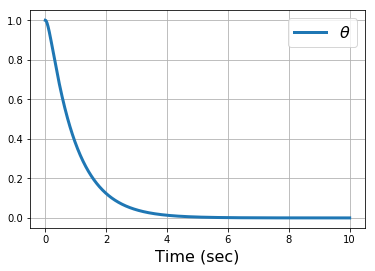

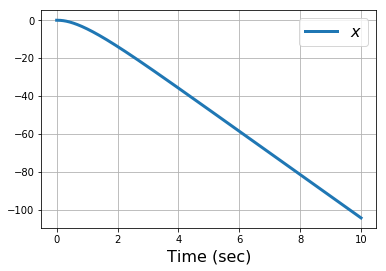

In [7]:
figure()
plot(ts, xs[:, 1], linewidth=3, label='$\\theta$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

figure()
plot(ts, xs[:, 0], linewidth=3, label='$x$')
grid()
legend(fontsize=16)
xlabel('Time (sec)', fontsize=16)

show()